In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, TrainerCallback, TrainerState, TrainerControl
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_dataset
# from transformers import Trainer
from transformers.integrations import TensorBoardCallback
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Params

In [ ]:
base = "/data/huggingface/meta/Llama-3.2-1B"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    device_map=None
)

In [ ]:
# Конфигурация QLoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(base_model, lora_config)
# model.gradient_checkpointing_enable()

# Загрузка и токенизация
dataset = load_dataset("csv", data_files="csv/traindataset_comma.csv")["train"].select(range(200))  # 20k

def tokenize(example):
    full_text = f"{example['instruction']}\n{example['output']}"
    return tokenizer(full_text, truncation=True, padding="max_length", max_length=256)

tokenized_ds = dataset.map(tokenize)

/opt/jupyter/lib/python3.10/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/opt/jupyter/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
Map: 100%|██████████| 200/200 [00:00<00:00, 1201.80 examples/s]


## Training args

In [ ]:
per_device_train_batch_size = 4
gradient_accumulation_steps = 8
optim = 'adamw_torch'
learning_rate = 2e-4
max_grad_norm = 1
warmup_ratio = 0.03
lr_scheduler_type = "linear"
dataloader_num_workers=8
logging_dir = "./logs/Llama-3.2-1B_FT_0.2"

# Functions

In [ ]:
from transformers import TrainerCallback

class CSVStepLogger(TrainerCallback):
    def __init__(self, out_dir="./logs/qlora", fname="metrics.csv"):
        os.makedirs(out_dir, exist_ok=True)
        self.fpath = os.path.join(out_dir, fname)
        self.fieldnames = None          # будем пополнять

    def _write_header(self):
        with open(self.fpath, "w", newline="") as f:
            csv.DictWriter(f, self.fieldnames).writeheader()

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        # добавляем гарантированные step/epoch
        logs = {"step": state.global_step,
                "epoch": state.epoch,
                **logs}

        # первый вызов или появились новые ключи → обновить header
        updated = False
        if self.fieldnames is None:
            self.fieldnames = list(logs.keys())
            updated = True
        else:
            for k in logs:
                if k not in self.fieldnames:
                    self.fieldnames.append(k)
                    updated = True
        if updated:
            self._write_header()        # переписываем заголовок

        # дописываем строку
        with open(self.fpath, "a", newline="") as f:
            writer = csv.DictWriter(
                f, fieldnames=self.fieldnames, extrasaction="ignore"
            )
            writer.writerow(logs)

In [ ]:
import math

n_samples = 1000
# те же значения, что вы передали в TrainingArguments
per_device_train_batch_size   = 8      # пример
gradient_accumulation_steps   = 8      # пример
num_train_epochs              = 3      # ← добавляем!

def countSPE(per_device_train_batch_size, gradient_accumulation_steps, num_train_epochs):
  eff_bs = per_device_train_batch_size * gradient_accumulation_steps
  steps_per_epoch = math.ceil(n_samples / eff_bs)
  total_steps = steps_per_epoch * num_train_epochs

  print(f"steps/epoch: {steps_per_epoch},  total steps: {total_steps}")

steps/epoch: 16,  total steps: 48


# Train

In [ ]:

training_args = TrainingArguments(
    # ─── catalogue ─────────────────────────────────────────────────────────
    output_dir              = "./qlora/Llama-3.2-1B_FT_0.2",
    logging_dir             = logging_dir,

    # ─── контроль чек-пойнтов ──────────────────────────────────────────────
    save_strategy           = "epoch",       # 1 × эпоха = 32 шага
    save_total_limit        = 3,             # храним только 3 лучших
    # load_best_model_at_end  = True,
    metric_for_best_model   = "eval_loss",

    # ─── логирование и валидация ───────────────────────────────────────────
    logging_strategy        = "steps",
    logging_steps           = 5,
    # evaluation_strategy   = "epoch",      # return error

    # ─── обучение ──────────────────────────────────────────────────────────
    num_train_epochs        = 3,
    per_device_train_batch_size = per_device_train_batch_size,
    gradient_accumulation_steps = gradient_accumulation_steps,
    group_by_length         = True,

    # ─── оптимизатор и расписание ──────────────────────────────────────────
    optim                   = optim,
    learning_rate           = learning_rate,
    weight_decay            = 0.01,          # лёгкая регуляризация
    max_grad_norm           = max_grad_norm,
    warmup_ratio            = warmup_ratio,
    lr_scheduler_type       = lr_scheduler_type,

    # ─── железо ────────────────────────────────────────────────────────────
    fp16                    = False,         # CPU ⇒ fp32
    bf16                    = False,
    use_cpu                 = True,          # no_cuda=True
    dataloader_num_workers  = dataloader_num_workers,

    # ─── телеметрия ────────────────────────────────────────────────────────
    report_to               = "none",
)

"""
`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
"""
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    processing_class=tokenizer,
    callbacks=[CSVStepLogger(logging_dir, "Llama-3.2-1B_FT_0.2.csv")],
)

PyTorch: setting up devices
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: input, output, instruction. If input, output, instruction are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 200
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 18
  Number of trainable parameters = 851,968


Step,Training Loss
10,1.955900


Saving model checkpoint to ./qlora/Llama-3.2-1B_FT_0.2/checkpoint-7
loading configuration file /data/huggingface/meta/Llama-3.2-1B/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.2",
  "use_cache": true,
  "vocab_size": 128

TrainOutput(global_step=18, training_loss=1.904447661505805, metrics={'train_runtime': 3496.5085, 'train_samples_per_second': 0.172, 'train_steps_per_second': 0.005, 'total_flos': 789920234864640.0, 'train_loss': 1.904447661505805, 'epoch': 2.64})

In [ ]:
%matplotlib inline

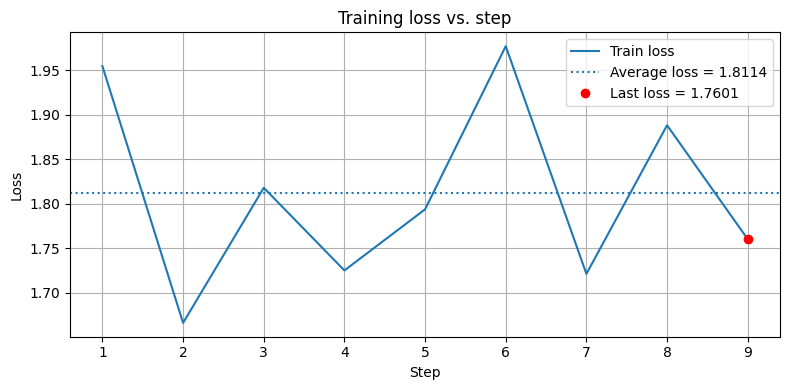

Average training loss: 1.8114
Last training loss:    1.7601


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Adjust the path if needed
csv_path = "./logs/qlora/metrics.csv"

# Load metrics
df = pd.read_csv(csv_path)

# Select rows where training loss is available
df_loss = df[df["loss"].notna()].copy()

# Compute statistics
avg_loss = df_loss["loss"].mean()
last_loss = df_loss["loss"].iloc[-1]

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df_loss["step"], df_loss["loss"], label="Train loss")

# Add average loss line
ax.axhline(avg_loss, linestyle=":", label=f"Average loss = {avg_loss:.4f}")

# Mark last loss point
ax.plot(df_loss["step"].iloc[-1], last_loss, "ro", label=f"Last loss = {last_loss:.4f}")

# Plot eval loss if available
if "eval_loss" in df.columns and df["eval_loss"].notna().any():
    ax.plot(df["step"], df["eval_loss"], linestyle="--", label="Eval loss")

ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.set_title("Training loss vs. step")
ax.grid(True)
ax.legend(loc="best")
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Average training loss: {avg_loss:.4f}")
print(f"Last training loss:    {last_loss:.4f}")

# Test model

In [ ]:
# Путь к твоей модели
model_path = "./final_model"  # <-- если ты скопировал checkpoint-750 в final_model

# Загружаем модель и токенизатор
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float32, device_map="auto")

# Функция генерации ответа
def generate_response(prompt, max_new_tokens=100):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]

    # Генерация
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.5,
            top_p=0.9,
            top_k=50,
            pad_token_id=tokenizer.eos_token_id
        )
    # Декодируем ответ
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

# Пример работы
user_prompt = "Что такое налоги?"
response = generate_response(user_prompt)
print(f"Вопрос: {user_prompt}\nОтвет: {response}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Вопрос: Что такое налоги?
Ответ: Что такое налоги? Какие налоги в России? Какие налоги в России для индивидуального предпринимателя? Какие налоги в России для физических лиц? Какие налоги в России для юридических лиц? Какие налоги в России для индивидуальных предпринимателей? Какие налоги в России для физических лиц? Какие налоги в России для юридических лиц? Какие налоги в России для индивидуальных пред


# Merge model

In [ ]:
from transformers import AutoModelForCausalLM
from peft import PeftModel

base = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype="float16")

loading configuration file /data/huggingface/meta/Llama-3.2-1B/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "float16",
  "transformers_version": "4.51.2",
  "use_cache": true,
  "vocab_size": 128256
}

loading weights file /data/huggingface/meta/Llama-3.2-1B/model

In [ ]:
ft_model.save_pretrained("/home/kgd_tazhibaev/qlora/Llama-3.2-1B_FT/full_model")
tokenizer.save_pretrained("/home/kgd_tazhibaev/qlora/Llama-3.2-1B_FT/full_model")

Configuration saved in /home/kgd_tazhibaev/qlora/Llama-3.2-1B_FT/full_model/config.json
Configuration saved in /home/kgd_tazhibaev/qlora/Llama-3.2-1B_FT/full_model/generation_config.json
Model weights saved in /home/kgd_tazhibaev/qlora/Llama-3.2-1B_FT/full_model/model.safetensors
tokenizer config file saved in /home/kgd_tazhibaev/qlora/Llama-3.2-1B_FT/full_model/tokenizer_config.json
Special tokens file saved in /home/kgd_tazhibaev/qlora/Llama-3.2-1B_FT/full_model/special_tokens_map.json


('/home/kgd_tazhibaev/qlora/Llama-3.2-1B_FT/full_model/tokenizer_config.json',
 '/home/kgd_tazhibaev/qlora/Llama-3.2-1B_FT/full_model/special_tokens_map.json',
 '/home/kgd_tazhibaev/qlora/Llama-3.2-1B_FT/full_model/tokenizer.json')